# GPT2, BERT and T5 for binary text classification

Data source: https://huggingface.co/datasets/stanfordnlp/sst2

In this notebook, I will compare different LLMs on the specific NLP task of classification.

**Task:** Predict text class rating (binary classification)

**Outcome:**
three trained models

*   GPT2
*   BERT
*   T5

# Preparation

### Import libraries

In [4]:
!pip install "numpy<2.0"

In [5]:
!pip install evaluate

In [6]:
import torch
from transformers import (
    GPT2Tokenizer, BertForSequenceClassification, TrainingArguments,
    Trainer, GPT2ForSequenceClassification, DataCollatorWithPadding,
    BertTokenizer, T5Tokenizer, T5ForConditionalGeneration, GPT2Config)
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, f1_score,
    roc_auc_score, precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc
)
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from datasets import Dataset, concatenate_datasets
from evaluate import load
import evaluate

In [19]:
!pip install -q fsspec==2023.6.0 gcsfs==2023.6.0

In [20]:
!pip install rouge_score

### Import data

Loading Stanford Sentiment Treebank

In [21]:
!mkdir -p glue_data/SST-2
!wget https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
!unzip -o SST-2.zip -d glue_data/SST-2

--2025-08-10 15:21:22--  https://dl.fbaipublicfiles.com/glue/data/SST-2.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.123, 13.35.37.111, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7439277 (7.1M) [application/zip]
Saving to: ‘SST-2.zip.1’

SST-2.zip.1         100%[===================>]   7.09M  --.-KB/s    in 0.07s   

2025-08-10 15:21:22 (103 MB/s) - ‘SST-2.zip.1’ saved [7439277/7439277]

Archive:  SST-2.zip
  inflating: glue_data/SST-2/SST-2/dev.tsv  
  inflating: glue_data/SST-2/SST-2/original/README.txt  
  inflating: glue_data/SST-2/SST-2/original/SOStr.txt  
  inflating: glue_data/SST-2/SST-2/original/STree.txt  
  inflating: glue_data/SST-2/SST-2/original/datasetSentences.txt  
  inflating: glue_data/SST-2/SST-2/original/datasetSplit.txt  
  inflating: glue_data/SST-2/SST-2/original/dictionary.txt  
  inflating: glue_data/SST-2/SST

In [22]:
base_path = "glue_data/SST-2/SST-2"

train_df = pd.read_csv(f"{base_path}/train.tsv", sep="\t")
val_df = pd.read_csv(f"{base_path}/dev.tsv", sep="\t")
test_df = pd.read_csv(f"{base_path}/test.tsv", sep="\t")
test_df = test_df.rename(columns={"index": "label"})

# to HuggingFace Dataset
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

print('train: ', train_ds[0])
print(train_ds[1])
print('Test: ', test_ds[0])
print('Val: ', val_ds[1])

train:  {'sentence': 'hide new secretions from the parental units ', 'label': 0}
{'sentence': 'contains no wit , only labored gags ', 'label': 0}
Test:  {'label': 0, 'sentence': 'uneasy mishmash of styles and genres .'}
Val:  {'sentence': 'unflinchingly bleak and desperate ', 'label': 0}


## Data exploration

Label distribution:
Negative: 29,780 samples
Positive: 37,569 samples


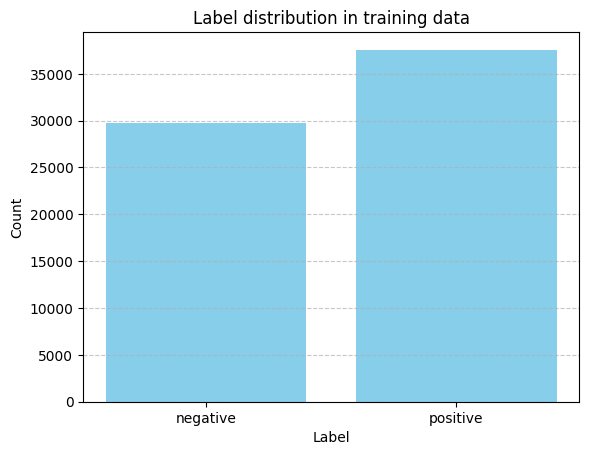

In [23]:
label_map = {0: "negative", 1: "positive"}
label_counts = Counter(train_ds["label"])
print("Label distribution:")
for label in sorted(label_counts):
  name = label_map[label]
  print(f"{name.capitalize()}: {label_counts[label]:,} samples")

labels = list(label_counts.keys())
counts = list(label_counts.values())
class_names = [label_map[label] for label in labels]

plt.bar(class_names, counts, color="skyblue")
plt.title("Label distribution in training data")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

I'm performing some oversampling of the negative class to ensure a balance between positive and negative examples.

In [24]:
# split up labels
negatives = train_ds.filter(lambda example: example["label"] == 0)
positives = train_ds.filter(lambda example: example["label"] == 1)

# adjust distribution
diff = len(positives) - len(negatives)
negatives_oversampled = negatives.shuffle(seed=42).select(range(diff))  # Zufällige Auswahl

# combine again
train_ds = concatenate_datasets([train_ds, negatives_oversampled]).shuffle(seed=42)

Filter:   0%|          | 0/67349 [00:00<?, ? examples/s]

Filter:   0%|          | 0/67349 [00:00<?, ? examples/s]

# Training

I'll evaluate each model based on these metrics:


*   **Accuracy** to determine how many predictions are correct overall
*   **Balanced Accuracy** to determine how well the accuracy is per class, regardless of the distribution of the classes
*   **Precision** to determine how many of the positive predictions are correct
*   **Recall** to determine how many positives my models find
*   **F1 score** to determine how good the classification quality is, in the compromise between precision and recall
*   **ROC AUC** to determine how well my models separate positive and negative classes from each other
*   **ROUGE** to determine how well the predicted classes match the actual ones

In [25]:
rouge_metric = evaluate.load("rouge")

# metric evaluation functions
def evaluate_model(model, dataloader, device):
  model.eval()
  all_labels, all_preds, all_probs = [], [], []
  total_loss = 0                                  # accumulate loss for entire dataset

  with torch.no_grad():
    for batch in dataloader:
      input_ids = batch["input_ids"].to(device)             # input IDs => represent tokens from the text = Token IDs
      attention_mask = batch["attention_mask"].to(device)   # make sure model doesn't take padding into account
      labels = batch["labels"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
      logits = outputs.logits                     # raw scores per class (before softmax)
      loss = outputs.loss

      probs = torch.softmax(logits, dim=1)[:, 1]  # logits to probabilities ([:, 1] --> class 1 (positive)); needed for ROC AUC
      preds = torch.argmax(logits, dim=1)         # actual predicted class (0 or 1); needed for accuracy, precision etc.

      # save all the results of the batches
      all_labels.extend(labels.cpu().numpy())
      all_preds.extend(preds.cpu().numpy())
      all_probs.extend(probs.cpu().numpy())
      total_loss += loss.item()                   # sum up loss per batch

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # turn num labels into text labels for rouge, to compare the string label names
    label_map = {0: "negative", 1: "positive"}
    text_preds = ["positive" if p == 1 else "negative" for p in all_preds]
    text_refs  = ["positive" if l == 1 else "negative" for l in all_labels]
    # calculate rouge
    rouge_result = rouge_metric.compute(predictions=text_preds, references=text_refs)

    # calculate all the metrics
    metrics = {
      "accuracy": accuracy_score(all_labels, all_preds),
      "balanced_accuracy": balanced_accuracy_score(all_labels, all_preds),
      "f1": f1_score(all_labels, all_preds),
      "roc_auc": roc_auc_score(all_labels, all_probs),
      "precision": precision_score(all_labels, all_preds),
      "recall": recall_score(all_labels, all_preds),
      "confusion_matrix": confusion_matrix(all_labels, all_preds),
      "val_loss": total_loss / len(dataloader),
      "rouge": rouge_result["rougeL"]
    }

  return metrics, all_labels, all_preds, all_probs

# plotting functions
def plot_learning_curves(train_losses, val_losses):
  plt.figure(figsize=(8, 4))
  plt.plot(train_losses, label="Train Loss", color="blue")
  plt.plot(val_losses, label="Validation Loss", color="red")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Learning Curves")
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_confusion_matrix(cm):
  labels = ["negative", "positive"]
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format='d')
  plt.title("Confusion Matrix")
  plt.grid(False)
  plt.show()

def plot_roc_curve(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
  plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend()
  plt.grid(True)
  plt.show()

## BERT

In [26]:
#tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_text(input_text):
  return tokenizer(input_text["sentence"], padding="max_length", truncation=True, max_length=128)

train_ds_bert = train_ds.map(tokenize_text, batched=True)
val_ds_bert = val_ds.map(tokenize_text, batched=True)
test_ds_bert = test_ds.map(tokenize_text, batched=True)

train_ds_bert = train_ds_bert.rename_column("label", "labels")
val_ds_bert = val_ds_bert.rename_column("label", "labels")
test_ds_bert = test_ds_bert.rename_column("label", "labels")

# give HuggingFace the values with the 'labels'-key + format for PyTorch so I can use DataLoader
train_ds_bert.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds_bert.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds_bert.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/75138 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

I'm freezing the layers (except the last encoder and pooler layer). Before I did this, my model showed signs of overfitting in the form of decreasing training loss and simultaneous increasing validation loss. Unfreezing only these last layers stabilized the model while speeding up training.

This solution made sense since the latter transformer blocks are covering knowledge needed for specific tasks.

In [27]:
# using a BERT model for binary classification
model_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)

# freeze all layers except last encoder and pooler
for name, param in model_bert.named_parameters():
    if not name.startswith("bert.encoder.layer.11") and not name.startswith("bert.pooler"):
        param.requires_grad = False

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model_bert.to(device)

if use_cuda:
    from torch.amp import autocast, GradScaler
    scaler = GradScaler()
else:
    from contextlib import nullcontext
    autocast = nullcontext  # use dummy context manager if no gpu is available
    scaler = None

In [29]:
# DataCollatorWithPadding for correct padding within each batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
# DataLoader for efficient shuffling of training data and loading
train_loader_bert = DataLoader(train_ds_bert, batch_size=32, shuffle=True, collate_fn=data_collator,
                          num_workers=2, pin_memory=True)
val_loader_bert = DataLoader(val_ds_bert, batch_size=32, shuffle=False, collate_fn=data_collator,
                        num_workers=2, pin_memory=True)

optimizer = Adam(filter(lambda p: p.requires_grad, model_bert.parameters()), lr=1e-5)

p_itr = 1000    # print interval for my logging
epochs = 5
train_losses = []
val_losses = []
best_val_loss = float("inf")
patience = 1    # for early stopping
counter = 0     # counter for early stopping

# forward pass, calculating loss
for epoch in range(epochs):
  model_bert.train()
  running_loss = 0
  total_correct = 0
  total_len = 0
  itr = 1
  temp_loss = 0
  temp_correct = 0
  temp_len = 0

  for batch in train_loader_bert:
      optimizer.zero_grad()
      # load batch components to device (gpu or cpu)
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      with autocast(device_type="cuda"):      # activates mixed precision --> quicker on gpu
          outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels) # embeddings
          loss = outputs.loss
          logits = outputs.logits

      # backward pass, optimization
      if scaler:
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
      else:
          loss.backward()
          optimizer.step() # update weights

      pred = torch.argmax(logits, dim=1)    # take class with highest probability
      correct = torch.sum(pred == labels)   # count amount of correct predictions
      total_correct += correct.item()
      total_len += len(labels)
      running_loss += loss.item()

      # values for logging
      temp_correct += correct.item()
      temp_len += len(labels)
      temp_loss += loss.item()

      # logging
      if itr % p_itr == 0:
          print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(
              epoch + 1, epochs, itr, temp_loss / p_itr, temp_correct / temp_len))
          temp_loss = 0
          temp_correct = 0
          temp_len = 0

      itr+=1

  # calculate average
  avg_train_loss = running_loss / len(train_loader_bert)
  train_losses.append(avg_train_loss)

  # evaluate based on validation data
  val_metrics_bert, y_true_bert, y_pred_bert, y_prob_bert = evaluate_model(model_bert, val_loader_bert, device)
  val_losses.append(val_metrics_bert["val_loss"])

  print(f"\n[Epoch {epoch+1}/{epochs} Summary] --> Train Loss: {avg_train_loss:.4f}, Train Acc: {total_correct/total_len:.3f}, Val Loss: {val_metrics_bert['val_loss']:.4f}, Val Acc: {val_metrics_bert['accuracy']:.3f}\n")

  # early stopping when validation loss stops decreasing
  if val_metrics_bert["val_loss"] < best_val_loss:
      best_val_loss = val_metrics_bert["val_loss"]
      counter = 0
      torch.save(model_bert.state_dict(), "best_model_bert.pt") # saving best model
      print("✅ Validation loss improved, saving model")
  else:
      counter += 1
      print(f"⚠️ No improvement. Early stopping counter: {counter}/{patience}")
      if counter >= patience:
          print("‼️Early stopping triggered‼️")
          break

[Epoch 1/5] Iteration 1000 -> Train Loss: 0.5701, Accuracy: 0.692
[Epoch 1/5] Iteration 2000 -> Train Loss: 0.4763, Accuracy: 0.773

[Epoch 1/5 Summary] --> Train Loss: 0.5147, Train Acc: 0.740, Val Loss: 0.2984, Val Acc: 0.880

✅ Validation loss improved, saving model
[Epoch 2/5] Iteration 1000 -> Train Loss: 0.4540, Accuracy: 0.784
[Epoch 2/5] Iteration 2000 -> Train Loss: 0.4462, Accuracy: 0.790

[Epoch 2/5 Summary] --> Train Loss: 0.4493, Train Acc: 0.787, Val Loss: 0.2709, Val Acc: 0.897

✅ Validation loss improved, saving model
[Epoch 3/5] Iteration 1000 -> Train Loss: 0.4375, Accuracy: 0.796
[Epoch 3/5] Iteration 2000 -> Train Loss: 0.4349, Accuracy: 0.797

[Epoch 3/5 Summary] --> Train Loss: 0.4353, Train Acc: 0.797, Val Loss: 0.2661, Val Acc: 0.903

✅ Validation loss improved, saving model
[Epoch 4/5] Iteration 1000 -> Train Loss: 0.4273, Accuracy: 0.802
[Epoch 4/5] Iteration 2000 -> Train Loss: 0.4279, Accuracy: 0.802

[Epoch 4/5 Summary] --> Train Loss: 0.4272, Train Acc: 0.

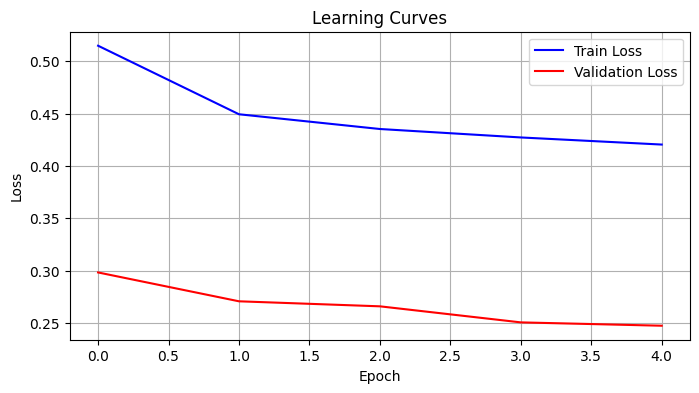

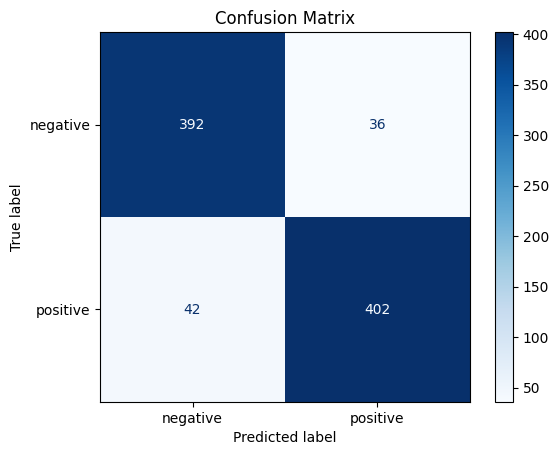

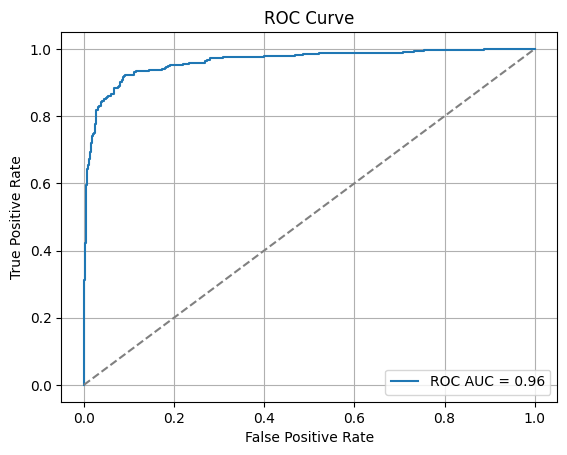


📊 Validation Metrics 📊
Precision    : 0.9178
Recall       : 0.9054
F1-Score     : 0.9116
Accuracy     : 0.9106
Balanced Acc.: 0.9106
ROC AUC      : 0.9629
ROUGE        : 0.9106
Validation Loss: 0.2476


In [30]:
# final plots
plot_learning_curves(train_losses, val_losses)
plot_confusion_matrix(val_metrics_bert["confusion_matrix"])
plot_roc_curve(y_true_bert, y_prob_bert)
val_metrics_bert, y_true_bert, y_pred_bert, y_prob_bert = evaluate_model(model_bert, val_loader_bert, device)

print(f"\n📊 Validation Metrics 📊")
print(f"Precision    : {val_metrics_bert['precision']:.4f}")
print(f"Recall       : {val_metrics_bert['recall']:.4f}")
print(f"F1-Score     : {val_metrics_bert['f1']:.4f}")
print(f"Accuracy     : {val_metrics_bert['accuracy']:.4f}")
print(f"Balanced Acc.: {val_metrics_bert['balanced_accuracy']:.4f}")
print(f"ROC AUC      : {val_metrics_bert['roc_auc']:.4f}")
print(f"ROUGE        : {val_metrics_bert['rouge']:.4f}")
print(f"Validation Loss: {val_metrics_bert['val_loss']:.4f}")

## GPT-2

In [31]:
# tokenization
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

def tokenize_text_gpt2(input_text):
  return gpt2_tokenizer(input_text["sentence"], padding="max_length", truncation=True, max_length=128)

train_ds_gpt2 = train_ds.map(tokenize_text_gpt2, batched=True)
val_ds_gpt2 = val_ds.map(tokenize_text_gpt2, batched=True)
test_ds_gpt2 = test_ds.map(tokenize_text_gpt2, batched=True)

train_ds_gpt2.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_ds_gpt2.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_ds_gpt2.set_format("torch", columns=["input_ids", "attention_mask", "label"])

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/75138 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [32]:
# using GPT2 model for classification tasks
config = GPT2Config.from_pretrained(
    "gpt2",
    num_labels=2
)
model_gpt2 = GPT2ForSequenceClassification.from_pretrained("gpt2", config=config)
model_gpt2.config.pad_token_id = model_gpt2.config.eos_token_id

# freeze lower layers
for i, block in enumerate(model_gpt2.transformer.h):
    if i < 8:
        for param in block.parameters():
            param.requires_grad = False

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# data loader
data_collator = DataCollatorWithPadding(tokenizer=gpt2_tokenizer, return_tensors="pt")

train_loader_gpt2 = DataLoader(train_ds_gpt2, batch_size=16, shuffle=True, collate_fn=data_collator)
val_loader_gpt2 = DataLoader(val_ds_gpt2, batch_size=16, shuffle=False, collate_fn=data_collator)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_gpt2.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=2, bias=False)
)

In [35]:
#!pip install "numpy<2.0"

In [ ]:
optimizer_gpt2 = Adam(model_gpt2.parameters(), lr=1e-5)
train_losses = []
val_losses = []
best_val_loss = float("inf")
patience = 1
counter = 0
epochs = 3
p_itr = 1000

for epoch in range(epochs):
    model_gpt2.train()
    running_loss = 0
    total_correct = 0
    total_len = 0
    temp_loss = 0
    temp_correct = 0
    temp_len = 0
    itr = 1

    for batch in train_loader_gpt2:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer_gpt2.zero_grad()      # reset gradients to zero
        outputs = model_gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer_gpt2.step()

        pred = torch.argmax(logits, dim=1)
        correct = torch.sum(pred == labels)
        running_loss += loss.item()
        total_correct += correct.item()
        total_len += len(labels)

        temp_correct += correct.item()
        temp_len += len(labels)
        temp_loss += loss.item()

        if itr % p_itr == 0:
            print(f"[Epoch {epoch+1}/{epochs}] Iteration {itr} -> Train Loss: {temp_loss/p_itr:.4f}, Accuracy: {temp_correct/temp_len:.3f}")
            temp_loss = 0
            temp_correct = 0
            temp_len = 0

        itr += 1

    avg_train_loss = running_loss / len(train_loader_gpt2)
    train_losses.append(avg_train_loss)

    # Evaluation
    val_metrics, y_true, y_pred, y_prob = evaluate_model(model_gpt2, val_loader_gpt2, device)
    val_losses.append(val_metrics["val_loss"])

    print(f"\n[Epoch {epoch+1}/{epochs} Summary] --> Train Loss: {avg_train_loss:.4f}, Train Acc: {total_correct/total_len:.3f}, Val Loss: {val_metrics['val_loss']:.4f}, Val Acc: {val_metrics['accuracy']:.3f}")
    print(f"F1: {val_metrics['f1']:.4f} | Precision: {val_metrics['precision']:.4f} | Recall: {val_metrics['recall']:.4f} | ROC AUC: {val_metrics['roc_auc']:.4f} | ROUGE: {val_metrics['rouge']:.4f}\n")

    # Early stopping
    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        counter = 0
        torch.save(model_gpt2.state_dict(), "best_model_gpt2.pt")
        print("✅ Validation loss improved, saving model")
    else:
        counter += 1
        print(f"⚠️ No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("‼️ Early stopping triggered ‼️")
            break

[Epoch 1/3] Iteration 1000 -> Train Loss: 0.6021, Accuracy: 0.680
[Epoch 1/3] Iteration 2000 -> Train Loss: 0.4048, Accuracy: 0.817
[Epoch 1/3] Iteration 3000 -> Train Loss: 0.3766, Accuracy: 0.834
[Epoch 1/3] Iteration 4000 -> Train Loss: 0.3506, Accuracy: 0.849

[Epoch 1/3 Summary] --> Train Loss: 0.4218, Train Acc: 0.802, Val Loss: 0.2865, Val Acc: 0.892
F1: 0.8951 | Precision: 0.8872 | Recall: 0.9032 | ROC AUC: 0.9533 | ROUGE: 0.8922

✅ Validation loss improved, saving model
[Epoch 2/3] Iteration 1000 -> Train Loss: 0.3216, Accuracy: 0.861
[Epoch 2/3] Iteration 2000 -> Train Loss: 0.3201, Accuracy: 0.861
[Epoch 2/3] Iteration 3000 -> Train Loss: 0.3147, Accuracy: 0.866


In [ ]:
# final plots
plot_learning_curves(train_losses, val_losses)
plot_confusion_matrix(val_metrics["confusion_matrix"])
plot_roc_curve(y_true, y_prob)
val_metrics_gpt2, y_true_gpt2, y_pred_gpt2, y_prob_gpt2 = evaluate_model(model_gpt2, val_loader_gpt2, device)

print(f"\n📊 Validation Metrics")
print(f"Precision    : {val_metrics_gpt2['precision']:.4f}")
print(f"Recall       : {val_metrics_gpt2['recall']:.4f}")
print(f"F1-Score     : {val_metrics_gpt2['f1']:.4f}")
print(f"Accuracy     : {val_metrics_gpt2['accuracy']:.4f}")
print(f"Balanced Acc.: {val_metrics_gpt2['balanced_accuracy']:.4f}")
print(f"ROC AUC      : {val_metrics_gpt2['roc_auc']:.4f}")
print(f"ROUGE        : {val_metrics_gpt2['rouge']:.4f}")
print(f"Validation Loss: {val_metrics_gpt2['val_loss']:.4f}")

## T5

In [ ]:
#tokenization
tokenizer_t5 = T5Tokenizer.from_pretrained("t5-base")

def tokenize_text(example):
  input_texts = ["Sentiment: " + s for s in example["sentence"]]
  target_texts = ["positive" if l == 1 else "negative" for l in example["label"]]   # labels as strings

  # input tokenization
  model_inputs = tokenizer_t5(input_texts, text_target=target_texts, padding="max_length", truncation=True, max_length=128)

  # target tokenization
  with tokenizer_t5.as_target_tokenizer():
    labels = tokenizer_t5(target_texts, padding="max_length", truncation=True, max_length=3)

  label_ids = labels["input_ids"]
  label_ids = [
        [(token if token != tokenizer_t5.pad_token_id else -100) for token in label_seq]
        for label_seq in label_ids
  ]
  model_inputs["labels"] = label_ids
  return model_inputs

train_ds_t5 = train_ds.map(tokenize_text, batched=True)
val_ds_t5 = val_ds.map(tokenize_text, batched=True)
test_ds_t5 = test_ds.map(tokenize_text, batched=True)

train_ds_t5.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds_t5.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_ds_t5.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [ ]:
# preparing the model
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-base")

# freeze everything (encoder, decoder, position embeddings)
for param in model_t5.parameters():
    param.requires_grad = False

# unfreeze last layer of language model
for param in model_t5.lm_head.parameters():
    param.requires_grad = True

In [ ]:
# data loader
data_collator = DataCollatorWithPadding(tokenizer=tokenizer_t5, return_tensors="pt")

train_loader_t5 = DataLoader(train_ds_t5, batch_size=16, shuffle=True, collate_fn=data_collator)
val_loader_t5 = DataLoader(val_ds_t5, batch_size=16, shuffle=False, collate_fn=data_collator)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_t5.to(device)

In [ ]:
# training loop
optimizer_t5 = Adam(model_t5.parameters(), lr=1e-5)
epochs = 3
train_losses = []
val_losses = []
best_val_loss = float("inf")
patience = 1
counter = 0
p_itr = 1000
total_preds = []
total_labels = []
temp_preds = []
temp_labels = []


for epoch in range(epochs):
    model_t5.train()
    running_loss = 0
    temp_loss = 0
    itr = 1
    temp_preds = []
    temp_labels = []

    for batch in train_loader_t5:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer_t5.zero_grad()
        outputs = model_t5(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer_t5.step()

        running_loss += loss.item()
        temp_loss += loss.item()

        # prediction
        generated_ids = model_t5.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=3)
        preds = tokenizer_t5.batch_decode(generated_ids, skip_special_tokens=True)
        labels_clean = labels.clone()
        labels_clean[labels_clean == -100] = tokenizer_t5.pad_token_id
        targets = tokenizer_t5.batch_decode(labels_clean, skip_special_tokens=True)

        temp_preds.extend(preds)
        temp_labels.extend(targets)

        if itr % p_itr == 0:
            acc = accuracy_score(temp_labels, temp_preds)
            print(f"[Epoch {epoch+1}/{epochs}] Iteration {itr} -> Train Loss: {temp_loss/p_itr:.4f}, Accuracy: {acc:.3f}")
            temp_loss = 0
            temp_preds = []
            temp_labels = []
        itr += 1

    avg_train_loss = running_loss / len(train_loader_t5)
    train_losses.append(avg_train_loss)

    # evaluation + early stopping
    model_t5.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader_t5:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model_t5(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    val_loss /= len(val_loader_t5)
    val_losses.append(val_loss)

    print(f"\n[Epoch {epoch+1}/{epochs} Summary] --> Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}\n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model_t5.state_dict(), "best_model_t5.pt")
        print("✅ Validation loss improved, saving model\n")
    else:
        counter += 1
        print(f"⚠️ No improvement. Early stopping counter: {counter}/{patience}")
        if counter >= patience:
            print("‼️ Early stopping triggered ‼️")
            break

In [ ]:
# load rouge metric module
rouge_metric = evaluate.load("rouge")

# eval prep
model_t5.eval()                                 # put model in evaluation mode
all_labels, all_preds = [], []                  # for numeric labels
decoded_preds, decoded_labels = [], []          # for text output for rouge calculation

# normalize text
def normalize_label(text):
    return text.strip().lower().replace(".", "").replace("!", "").replace(" ", "")

# mapping text label to num label
str2label = {"negative": 0, "positive": 1}

# evaluation loop
with torch.no_grad():                                         # no gradient computed, to save time and memory
    for batch in val_loader_t5:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # generate predictions
        generated_ids = model_t5.generate(                    # generate output text, e.g. "positive"
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=3
        )

        # decoding
        pred_texts = tokenizer_t5.batch_decode(generated_ids, skip_special_tokens=True)
        labels_clean = labels.clone()
        labels_clean[labels_clean == -100] = tokenizer_t5.pad_token_id
        label_texts = tokenizer_t5.batch_decode(labels_clean, skip_special_tokens=True)

        # save textual values for rouge
        decoded_preds.extend(pred_texts)
        decoded_labels.extend(label_texts)

        # mapping to num labels for classification
        for ref, pred in zip(label_texts, pred_texts):
            ref_norm = normalize_label(ref)
            pred_norm = normalize_label(pred)
            if ref_norm in str2label and pred_norm in str2label:        # "negative": 0, "positive": 1
                all_labels.append(str2label[ref_norm])
                all_preds.append(str2label[pred_norm])

# if the model didn't produce any valid predictions or labels set metrics to zero
if len(all_labels) == 0 or len(all_preds) == 0:
    print("⚠️ No valid predictions or labels, all metrics skipped")
    val_metrics_t5 = {
        "accuracy": 0.0,
        "balanced_accuracy": 0.0,
        "f1": 0.0,
        "precision": 0.0,
        "recall": 0.0,
        "confusion_matrix": [[0, 0], [0, 0]],
        "rouge": 0.0,
    }
else:
    # calc rouge: rate text similarity between predicted and actual
    rouge_result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels)

    # calc metrics
    val_metrics_t5 = {
        "accuracy": accuracy_score(all_labels, all_preds),
        "balanced_accuracy": balanced_accuracy_score(all_labels, all_preds),
        "f1": f1_score(all_labels, all_preds, zero_division=0),
        "precision": precision_score(all_labels, all_preds, zero_division=0),
        "recall": recall_score(all_labels, all_preds, zero_division=0),
        "confusion_matrix": confusion_matrix(all_labels, all_preds),
        "rouge": rouge_result["rougeL"],
    }

    # plots
    plot_learning_curves(train_losses, val_losses)
    plot_confusion_matrix(val_metrics_t5["confusion_matrix"])

# output
print(f"\n📊 Validation Metrics")
for k, v in val_metrics_t5.items():
    if k.startswith("rouge") or k.endswith("accuracy") or k in ["f1", "precision", "recall"]:
        print(f"{k:<18}: {v:.4f}")

# debug with examples
print("\nsome examples")
for i in range(min(5, len(decoded_preds))):
    print(f"actual: '{decoded_labels[i]}' --> pred: '{decoded_preds[i]}'")



---

## Conclusion

The training of BERT was quick and brought good results, while GPT-2 shows signs of overfitting even after unfreezing only the top layers. The T5 model shows a lot of promise, differentiating well between the classes.
At this point, I'd continue tweaking BERT and T5 to optimize the results, but wouldn't spend more ressources on GPT-2.



---

**Sources:**

I used GitHub repos and Colab notebooks, as inspiration and guidance for how to accomplish this task
BERT: https://github.com/zzaebok/PytorchBertExample/blob/master/BertForSequenceClassification_%EC%98%88%EC%A0%9C.ipynb

GPT2: https://colab.research.google.com/drive/1dMTdO5vxdVX0NA2Qe7AV9WGEy8ZH67Xn?usp=sharing#scrollTo=7dc4a339

T5: https://www.kaggle.com/code/prithvijaunjale/t5-multi-label-classification/notebook

I used the help of ChatGPT to debug when I had errors I didn't manage to fix on my own, especially for the T5 model.